In [1]:
# Import potřebných knihoven
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import FingerprintSimilarity, DiceSimilarity, TanimotoSimilarity
from rdkit import DataStructs

In [2]:
# Cesta k souboru s daty
soubor = "compounds.csv"

# Načtení datasetu s oddělovačem ';'
df = pd.read_csv(soubor, delimiter=';')

# Výběr relevantních sloupců
df = df[['name', 'smiles']].dropna()

In [3]:
# Konverze SMILES na molekuly.
# Každý SMILES řetězec převedeme na RDKit molekulární objekt.

df['molecule'] = df['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [8]:
# Výpočet molekulárních otisků.
# Použijeme různé typy otisků pro každou molekulu.

def get_fingerprints(mol):
    if mol:
        return {
            'Morgan': AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048),
            'MACCS': Chem.rdMolDescriptors.GetMACCSKeysFingerprint(mol),
        }
    return None

df['fingerprints'] = df['molecule'].apply(get_fingerprints)

[10:59:13] DEPRECATION WARNING: please use MorganGenerator
[10:59:13] DEPRECATION WARNING: please use MorganGenerator
[10:59:13] DEPRECATION WARNING: please use MorganGenerator
[10:59:13] DEPRECATION WARNING: please use MorganGenerator
[10:59:13] DEPRECATION WARNING: please use MorganGenerator
[10:59:13] DEPRECATION WARNING: please use MorganGenerator
[10:59:13] DEPRECATION WARNING: please use MorganGenerator
[10:59:13] DEPRECATION WARNING: please use MorganGenerator


In [9]:
# Výpočet podobností s referenční sloučeninou.
# Jako referenční sloučeninu použijeme levodopu a spočítáme podobnost pomocí různých metrik.

# SMILES pro levodopu
levodopa_smiles = "C1=CC(=C(C=C1CC(C(=O)O)N)O)O"
levodopa_mol = Chem.MolFromSmiles(levodopa_smiles)
levodopa_fps = get_fingerprints(levodopa_mol)

# Výpočet podobnosti pomocí různých metrik
def compute_similarities(fps, ref_fps):
    if fps:
        return {
            'Tanimoto_Morgan': DataStructs.FingerprintSimilarity(ref_fps['Morgan'], fps['Morgan']),
            'Dice_Morgan': DataStructs.DiceSimilarity(ref_fps['Morgan'], fps['Morgan']),
            'Tanimoto_MACCS': DataStructs.FingerprintSimilarity(ref_fps['MACCS'], fps['MACCS']),
            'Dice_MACCS': DataStructs.DiceSimilarity(ref_fps['MACCS'], fps['MACCS']),
        }
    return None

df['similarities'] = df['fingerprints'].apply(lambda x: compute_similarities(x, levodopa_fps))

[10:59:25] DEPRECATION WARNING: please use MorganGenerator


In [10]:
# Seřazení a výběr nejlepších shod.
# Seřadíme sloučeniny podle různých metrik podobnosti a zobrazíme tři nejpodobnější.

def extract_similarity(df, metric):
    return df.apply(lambda x: x['similarities'][metric] if x['similarities'] else None, axis=1)

for metric in ['Tanimoto_Morgan', 'Dice_Morgan', 'Tanimoto_MACCS', 'Dice_MACCS']:
    df[metric] = extract_similarity(df, metric)

top_hits = df.sort_values(by='Tanimoto_Morgan', ascending=False).head(3)

# Výpis výsledků
print("Top 3 nejpodobnější sloučeniny k levodopě podle Tanimoto-Morgan:")
print(top_hits[['name', 'smiles', 'Tanimoto_Morgan']])

Top 3 nejpodobnější sloučeniny k levodopě podle Tanimoto-Morgan:
                            name                             smiles  \
5                L-DOPA (sodium)  C1=CC(=C(C=C1CC(C(=O)O)N)O)O.[Na]   
6  Tyrosine, 3-hydroxy-O-methyl-      COC1=C(C=C(C=C1)CC(C(=O)O)N)O   
7              3-Methoxytyrosine      COC1=C(C=CC(=C1)CC(C(=O)O)N)O   

   Tanimoto_Morgan  
5         0.964286  
6         0.666667  
7         0.666667  


C:\Users\cerma\AppData\Local\Temp\ipykernel_12812\2690142446.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['name'], rotation=90)


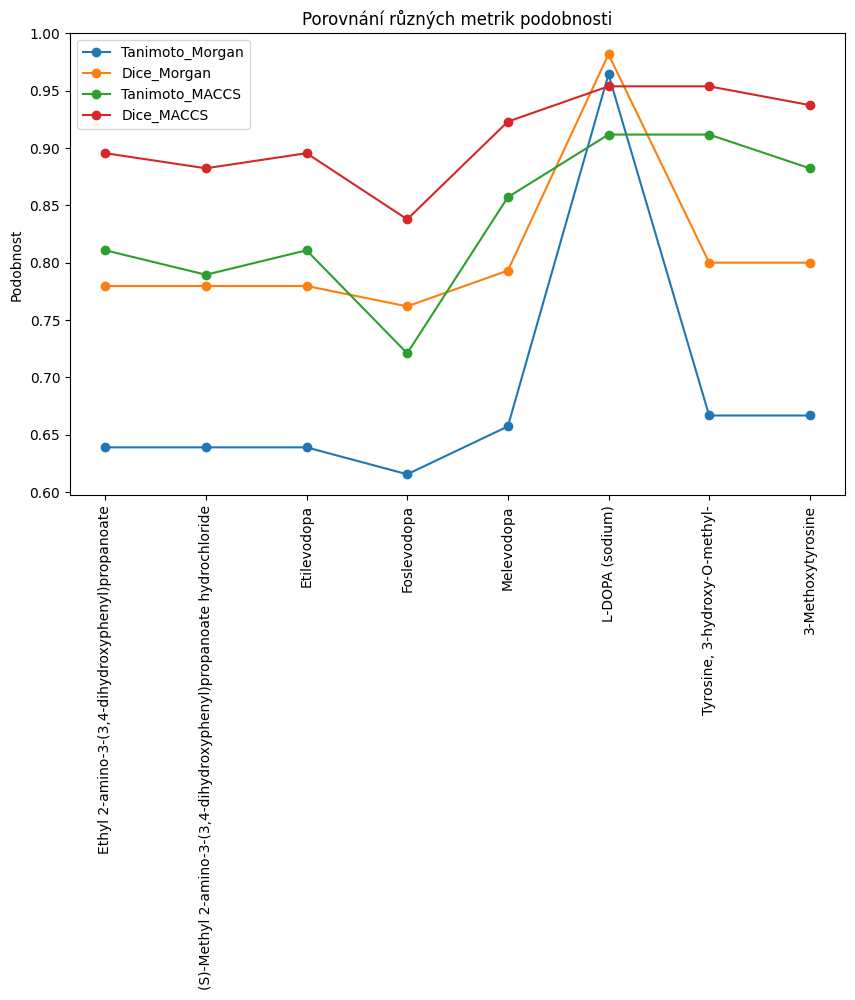

In [11]:
"""
Grafické srovnání různých metrik podobnosti.
Vytvoříme srovnávací graf pro různé metriky a různé otisky.
"""

fig, ax = plt.subplots(figsize=(10, 6))
metrics = ['Tanimoto_Morgan', 'Dice_Morgan', 'Tanimoto_MACCS', 'Dice_MACCS']
for metric in metrics:
    ax.plot(df['name'], df[metric], marker='o', linestyle='-', label=metric)

ax.set_xticklabels(df['name'], rotation=90)
ax.set_ylabel("Podobnost")
ax.set_title("Porovnání různých metrik podobnosti")
ax.legend()
plt.show()